## 2D Deconvolution on CUDA GPUs

In [3]:
using Revise, DeconvOptim, TestImages, Noise, CUDA, ImageShow, Colors, FFTW, Napari
FFTW.set_num_threads(4)
CUDA.allowscalar(false);

h_view(args...) = begin
    img = cat(args..., dims=2)
    img ./= maximum(img)
    Gray.(img)
end

h_view (generic function with 1 method)

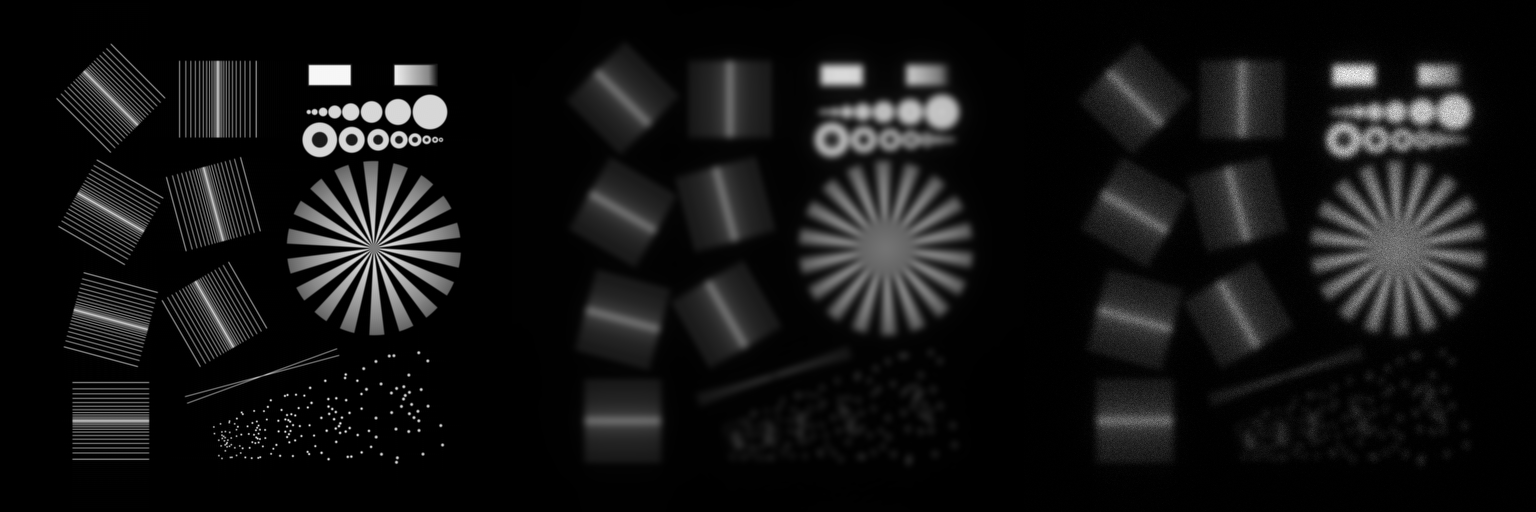

In [50]:
# load test images
img = Float32.(testimage("resolution_test_512"))

psf = Float32.(generate_psf(size(img), 30))
psf_c = CuArray(psf)
# create a blurred, noisy version of that image
img_b = conv_psf(img, psf)
img_n = poisson(img_b, 300);

img_n_c = CuArray(img_n)
h_view(img, img_b, img_n)

In [43]:
reg = TV(mode="forward")

#113 (generic function with 1 method)

In [61]:
@time resG, optim_res = deconvolution(img_n, psf, loss=Poisson(), regularizer=reg, λ=0.005, iterations=20)

  0.613815 seconds (66.17 k allocations: 1.286 GiB, 8.03% gc time)


(Float32[3.028249f-6 3.4237078f-6 … 4.3845985f-6 3.6514773f-6; 1.1083291f-6 1.7490242f-6 … 2.916858f-6 1.6021677f-6; … ; 3.8122498f-6 3.937827f-6 … 4.424708f-6 4.199716f-6; 3.9477877f-6 4.1260855f-6 … 4.6619816f-6 4.326276f-6],  * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     5.317861e+04

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.73e-02 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.66e-02 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.80e-01 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.38e-06 ≰ 0.0e+00
    |g(x)|                 = 3.83e-02 ≰ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    20
    f(x) calls:    61
    ∇f(x) calls:   61
)

In [62]:
@time resG_c, optim_res_c = deconvolution(img_n_c, psf_c, loss=Poisson(), regularizer=reg_gpu, λ=0.005, iterations=20)

  0.139167 seconds (186.14 k allocations: 88.010 MiB, 3.56% gc time)


(Float32[3.0201186f-6 3.416249f-6 … 4.380531f-6 3.6436013f-6; 1.1016358f-6 1.7412345f-6 … 2.9080554f-6 1.5941165f-6; … ; 3.8035787f-6 3.9298634f-6 … 4.4193744f-6 4.1917224f-6; 3.940575f-6 4.1198173f-6 … 4.660843f-6 4.3205196f-6],  * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     5.317861e+04

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.72e-02 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.65e-02 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.76e-01 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.31e-06 ≰ 0.0e+00
    |g(x)|                 = 3.76e-02 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    20
    f(x) calls:    81
    ∇f(x) calls:   81
)

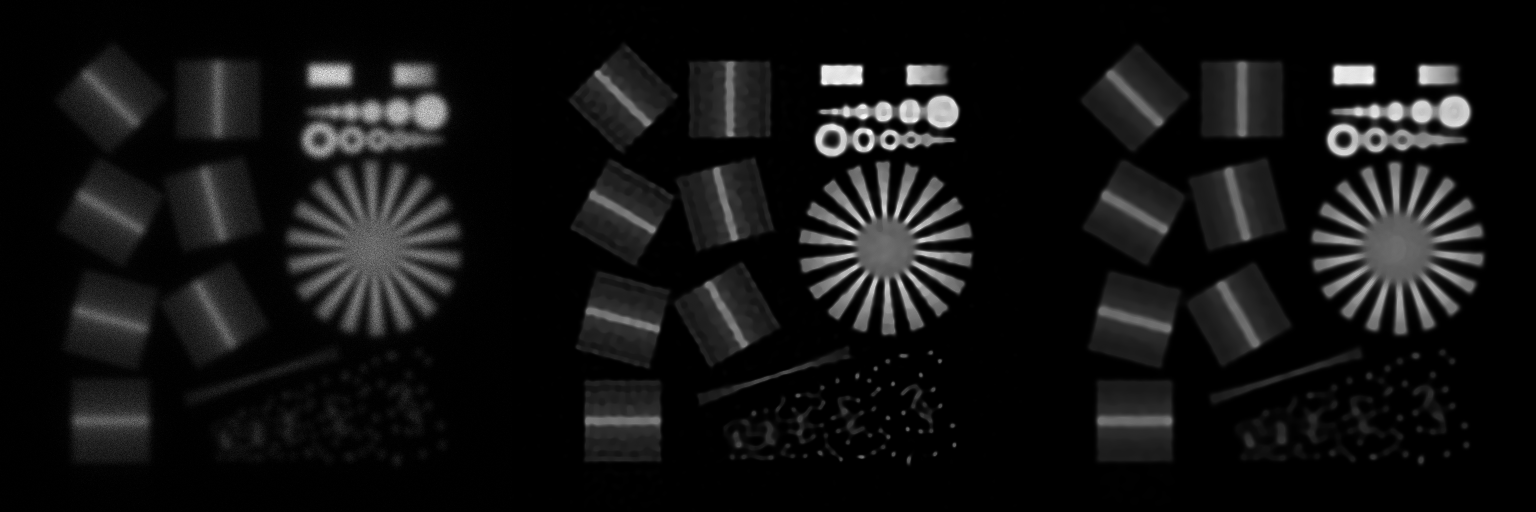

In [58]:
h_view(Array(img_n_c), Array(resG_c), Array(resG))

In [60]:
napari.view_image(Array(resG_c))
napari.view_image(Array(resG))
napari.view_image(Array(img_n))

PyObject <napari.viewer.Viewer object at 0x7f8bcbceacd0>